# 
<h1 style="color: teal;">3D Deconvolution Benchmark: Python SimpleITK</h1>

In [1]:
import napari
import tifffile as tiff
import glob
import numpy as np

# Crear viewer 3D
viewer = napari.Viewer(ndisplay=3)

# Colormaps y opacidades para los canales
colormaps = ['red', 'green', 'blue']

# Cargar y añadir cada canal
for i, channel_path in enumerate(["CElegans-CY3/*.tif", "CElegans-DAPI/*.tif", "CElegans-FITC/*.tif"]):
    files = sorted(glob.glob(channel_path))
    if len(files) == 0:
        continue
    stack = np.array([tiff.imread(f) for f in files])  # shape (Z, Y, X)
    viewer.add_image(stack, name=f'canal_{i+1}', colormap=colormaps[i])

# Dimensiones del volumen para los ejes
Z, Y, X = stack.shape

# Crear ejes X, Y, Z
axes_lines = [
    np.array([[0, 0, 0], [Z, 0, 0]]),  # eje Z
    np.array([[0, 0, 0], [0, Y, 0]]),  # eje Y
    np.array([[0, 0, 0], [0, 0, X]])   # eje X
]

viewer.add_vectors(axes_lines, edge_color=['red', 'green', 'blue'], edge_width=3)

napari.run()

/Users/yi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Assistant skips harvesting pyclesperanto as it's not installed.


---
## Setup

Python, por defecto, ejecuta el código en un solo hilo, y cuando no hay ninguna paralelización explícita, no se distribuyen las tareas entre varios núcleos.

In [2]:
import numpy as np
from skimage.io import imread, imsave
from skimage.data import cells3d
from skimage.filters import gaussian
from scipy.ndimage import convolve
from napari_simpleitk_image_processing import richardson_lucy_deconvolution
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from skimage import img_as_float
import imageio.v2 as iio
import tifffile as tiff
from PIL import Image
import os

/Users/yi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [21]:
import matplotlib.gridspec as gridspec

def plot_orthogonal_views(volume_3d, save_path=None, dpi=300):
    Z, Y, X = volume_3d.shape

    # Cortes centrales
    z_center = Z // 2
    y_center = Y // 2
    x_center = X // 2

    slice_xy = volume_3d[z_center, :, :]   # (Y, X)
    slice_xz = volume_3d[:, y_center, :]   # (Z, X)
    slice_yz = volume_3d[:, :, x_center]   # (Z, Y)

    # Normalizamos
    norm = lambda s: (s - s.min()) / (s.max() - s.min() + 1e-9)
    slice_xy_norm = norm(slice_xy)
    slice_xz_norm = norm(slice_xz)
    slice_yz_norm = norm(slice_yz)

    # Colormap fluorescente rojo
    fluorescent_red = LinearSegmentedColormap.from_list('fluoro_red', ['black', (1,0,0)])
    fluorescent_green = LinearSegmentedColormap.from_list('fluoro_green', ['black', (0,1,0)])
    fluorescent_blue = LinearSegmentedColormap.from_list('fluoro_green', ['black', (0,0,1)])
    # Crear figura
    fig = plt.figure(figsize=(8, 8))
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[X, Z], height_ratios=[Y, Z],
                       wspace=0, hspace=0.01)

    # XY (arriba izquierda)
    ax_xy = fig.add_subplot(gs[0, 0])
    ax_xy.imshow(slice_xy_norm, cmap=fluorescent_blue,
             extent=[0, X, 0, Y])
    ax_xy.axis('off')

    # YZ (arriba derecha, pegada a XY)
    ax_yz = fig.add_subplot(gs[0, 1])
    yz_rotated = np.rot90(slice_yz_norm, k=-1)
    ax_yz.imshow(yz_rotated, cmap=fluorescent_blue,
             extent=[0, Z, 0, Y])
    ax_yz.axis('off')

    # XZ (abajo izquierda, pegada a XY)
    ax_xz = fig.add_subplot(gs[1, 0])
    ax_xz.imshow(slice_xz_norm, cmap=fluorescent_blue,
             extent=[0, X, 0, Z])
    ax_xz.axis('off')

    # Hueco (abajo derecha)
    ax_empty = fig.add_subplot(gs[1, 1])
    ax_empty.axis("off")


    plt.show()

    if save_path is not None:
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight')


---
## Generación de los volúmenes

Cells3D

In [154]:
image_cell = img_as_float(iio.imread("ImagenesEmpleadas3D/cells3d.tif"))[:,1,119:190,79:150]

(-0.5, 70.5, 70.5, -0.5)

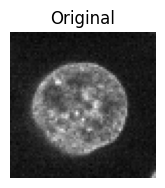

In [155]:
plt.subplot(1, 3, 1)
plt.imshow(image_cell[30], cmap='gray')
plt.title('Original')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

In [160]:
image_cell.shape

(60, 71, 71)

(-0.5, 70.5, 70.5, -0.5)

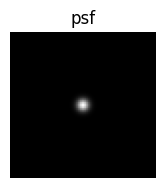

In [161]:
perfect_psf = np.zeros( (60,71,71) )
perfect_psf[30,35,35] = 1
psf = gaussian(perfect_psf, sigma=2)

plt.subplot(1, 3, 1)
plt.imshow(psf[31], cmap='gray')
plt.title('psf')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

In [162]:
psf.shape

(60, 71, 71)

(-0.5, 70.5, 70.5, -0.5)

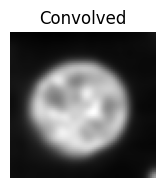

In [163]:
convolved_cell = convolve(image_cell, psf)

plt.subplot(1, 3, 1)
plt.imshow(convolved_cell[30], cmap='gray')
plt.title('Convolved')
plt.axis('off') 

In [164]:
convolved_cell.shape

(60, 71, 71)

In [165]:
# Guarda como stack TIFF
tiff.imwrite("3Dconvolved_cell.tif", convolved_cell.astype("float32"))

In [166]:
tiff.imwrite("3Dconvolved_cell_psf.tif", psf.astype("float32"))

Cube of Spherical Beads

In [114]:
# Cargamos la imagen
cubeImg = img_as_float(iio.imread("ref.tif"))

# Cargamos la PSF

cubePSF = img_as_float(iio.imread("cube_psf.tif"))[48:80,48:80,48:80]

print(cubeImg.shape)
print(cubePSF.shape)

(128, 128, 128)
(32, 32, 32)


(-0.5, 127.5, 127.5, -0.5)

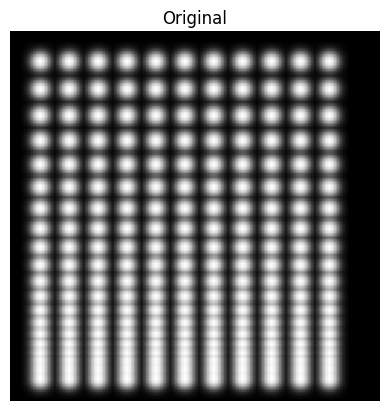

In [116]:
plt.imshow(cubeImg[30], cmap='gray')
plt.title('Original')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

In [117]:
cubeConvolved = convolve(cubeImg, cubePSF)

#tiff.imwrite('cube_convolved.tif', cubeConvolved.astype('float32'))

(-0.5, 127.5, 127.5, -0.5)

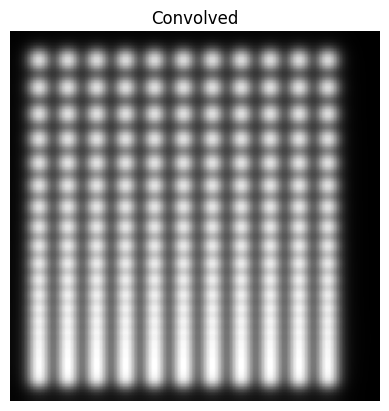

In [118]:
plt.imshow(cubeConvolved[30], cmap='gray')
plt.title('Convolved')
plt.axis('off') 

---
## Test Image

In [29]:
imageTest = img_as_float(iio.imread("ImagenesEmpleadas3D/simple_3d_ball.tif"))

(-0.5, 63.5, 63.5, -0.5)

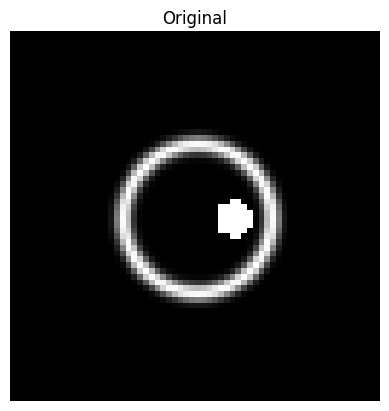

In [30]:
plt.imshow(imageTest[32], cmap='gray')
plt.title('Original')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

Cargamos la imagen degradada y la PSF:

In [31]:
psfTest = img_as_float(iio.imread("ImagenesEmpleadas3D/simple_3d_psf.tif"))

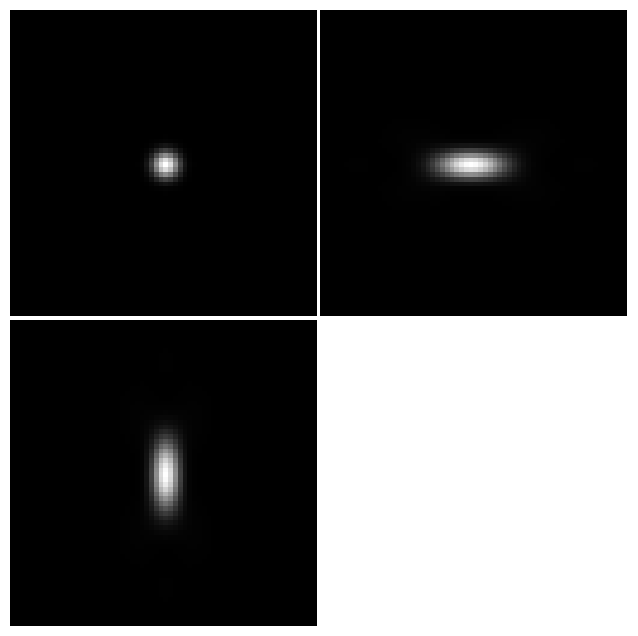

In [91]:
# Para tu volumen deconvolucionado
plot_orthogonal_views(psfTest, 
                      save_path="orthogonal_testimage_psf_python.png")

In [100]:
img_n = img_as_float(iio.imread("ImagenesEmpleadas3D/simple_3d_ball_blurred.tif"))

(-0.5, 63.5, 63.5, -0.5)

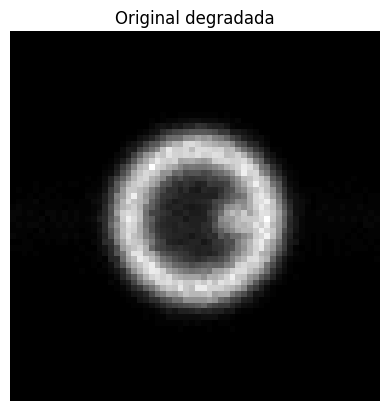

In [33]:
plt.imshow(img_n[32], cmap='gray')
plt.title('Original degradada')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

Visualización ortogonal:

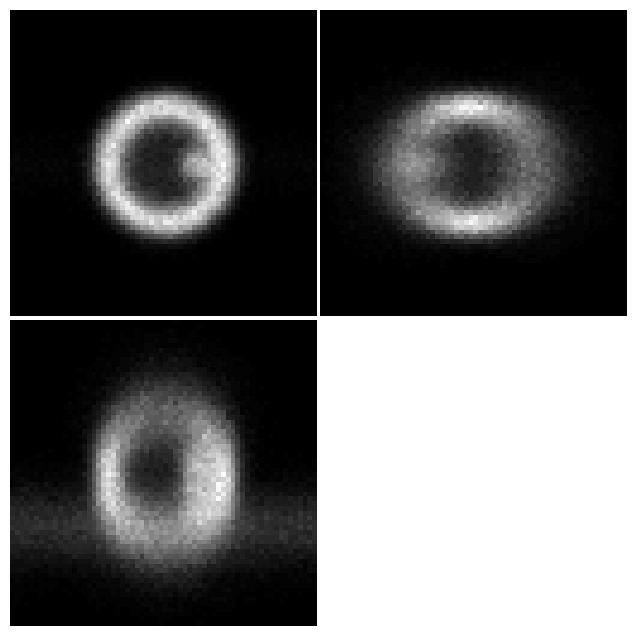

In [44]:
# Para tu volumen deconvolucionado
plot_orthogonal_views(img_n, 
                      save_path="orthogonal_testimage_borrosa_python.png")

In [45]:
#plt.imsave("3D_imagetest_slice32.png", img_n[32], cmap='gray')

Sin regularizador

In [46]:
number_of_iterations = 30
deconvolvedTest = richardson_lucy_deconvolution(img_n, psfTest, number_of_iterations)

(-0.5, 63.5, 63.5, -0.5)

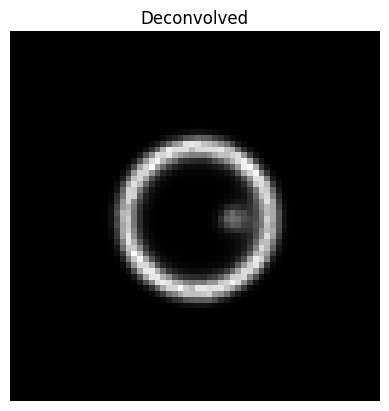

In [47]:
plt.imshow(deconvolvedTest[32], cmap='gray')
plt.title('Deconvolved')
plt.axis('off') 

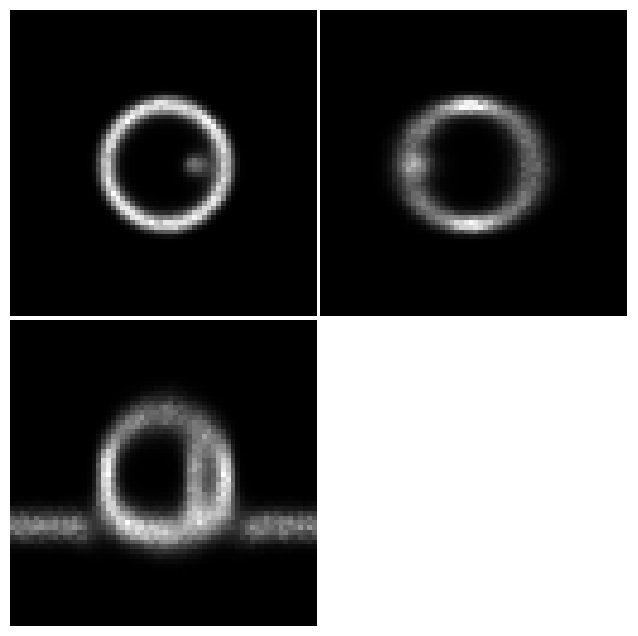

In [48]:
# Para tu volumen deconvolucionado
plot_orthogonal_views(deconvolvedTest, 
                      save_path="deconvolved_test_ortogonal_python.png")


<h3 style="color: green;">@ Benchmark</h3>

In [126]:
%timeit -n 1 -r 10  richardson_lucy_deconvolution(img_n, psfTest, number_of_iterations)

16.9 s ± 166 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


---
## Cells 3D

Cargamos la imagen degradada y la PSF:

In [3]:
image_cell_borrosa = img_as_float(iio.imread("ImagenesEmpleadas3D/3Dconvolved_cell.tif"))

In [50]:
image_cell_borrosa.shape

(60, 71, 71)

(-0.5, 70.5, 70.5, -0.5)

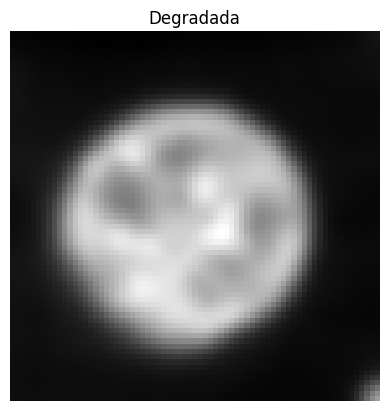

In [51]:
plt.imshow(image_cell_borrosa[30], cmap='gray')
plt.title('Degradada')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

Visualización ortogonal:

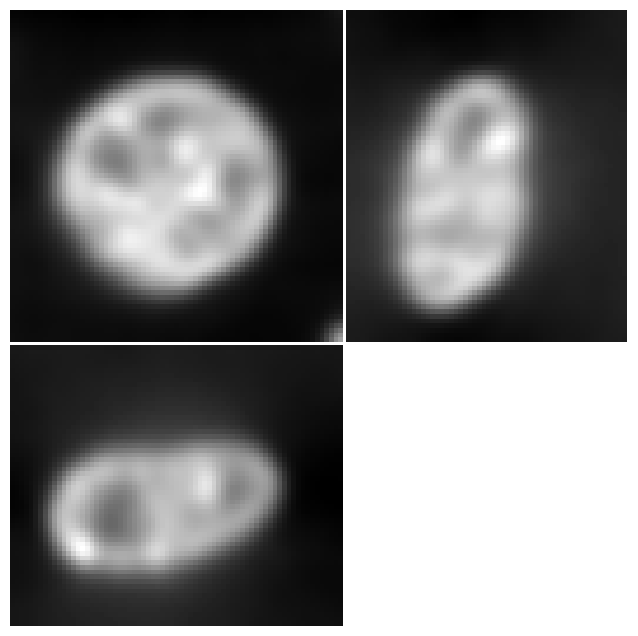

In [4]:
plot_orthogonal_views(image_cell_borrosa, 
                      save_path="otogonal_cell3D_original_python.png")

In [43]:
#plt.imsave("3D_imagecell_slice30.png", image_cell_borrosa[30], cmap='gray')

In [64]:
psf_cell = img_as_float(iio.imread("ImagenesEmpleadas3D/3Dconvolved_cell_psf.tif"))

In [65]:
psf_cell.shape

(60, 71, 71)

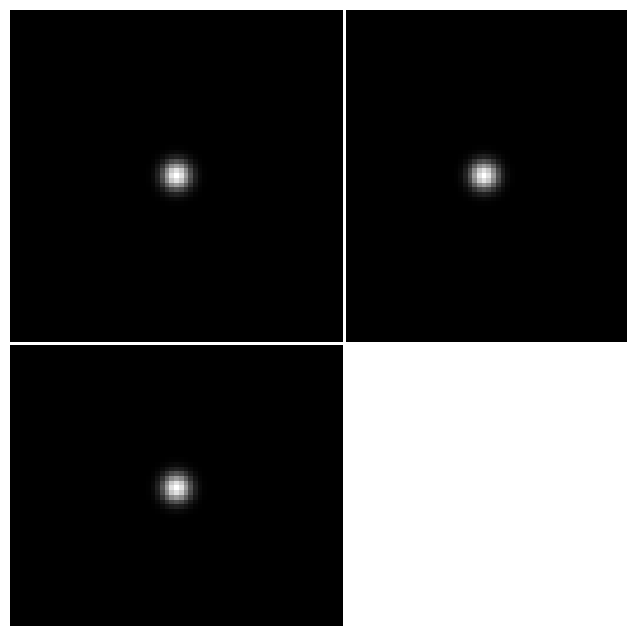

In [92]:
plot_orthogonal_views(psf_cell, 
                      save_path="otogonal_cell3D_psf_python.png")

In [66]:
number_of_iterations = 30
deconvolved_cell = richardson_lucy_deconvolution(image_cell_borrosa, psf_cell, number_of_iterations)

(-0.5, 70.5, 70.5, -0.5)

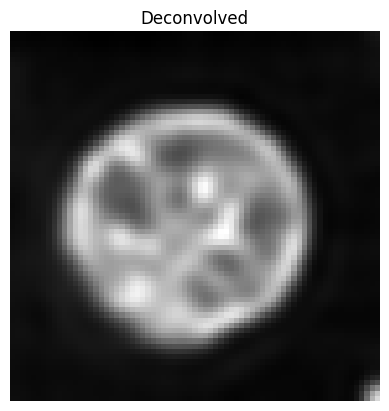

In [67]:
plt.imshow(deconvolved_cell[30], cmap='gray')
plt.title('Deconvolved')
plt.axis('off') 

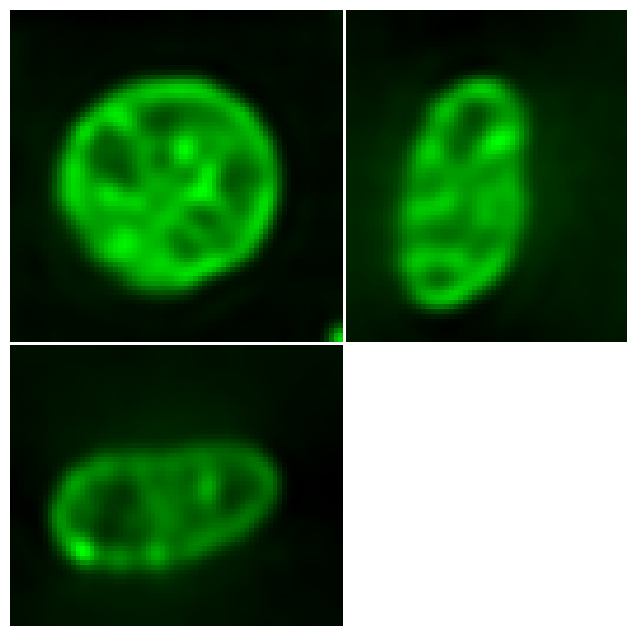

In [68]:
# Para tu volumen deconvolucionado
plot_orthogonal_views(deconvolved_cell, 
                      save_path="otogonal_deconvolved_cell_python.png")


<h3 style="color: green;">@ Benchmark</h3>

In [174]:
%timeit -n 1 -r 10  richardson_lucy_deconvolution(image_cell_borrosa, psf_cell, number_of_iterations)

9.76 s ± 154 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


---
## Cube of Spherical Beads

In [53]:
cube_beads_borrosa = img_as_float(iio.imread("ImagenesEmpleadas3D/cube_convolved.tif"))

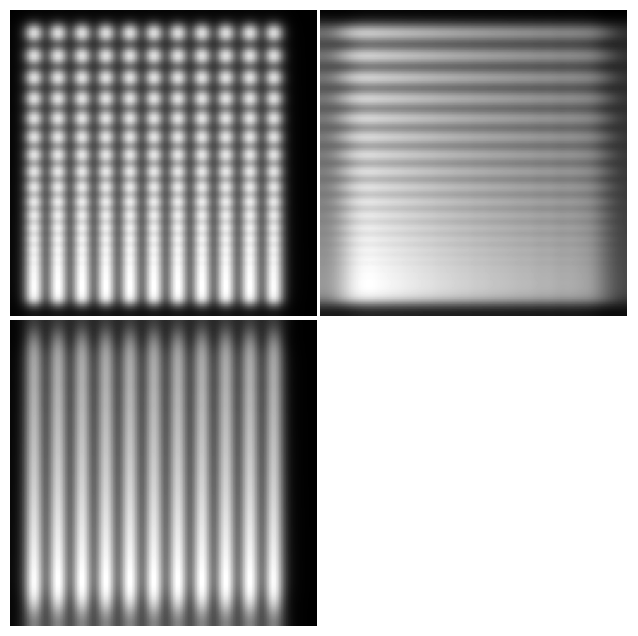

In [55]:
plot_orthogonal_views(cube_beads_borrosa, 
                      save_path="ortogonal_cube_original_python.png")

In [54]:
cube_beads_psf = img_as_float(iio.imread("ImagenesEmpleadas3D/cube_psf.tif"))

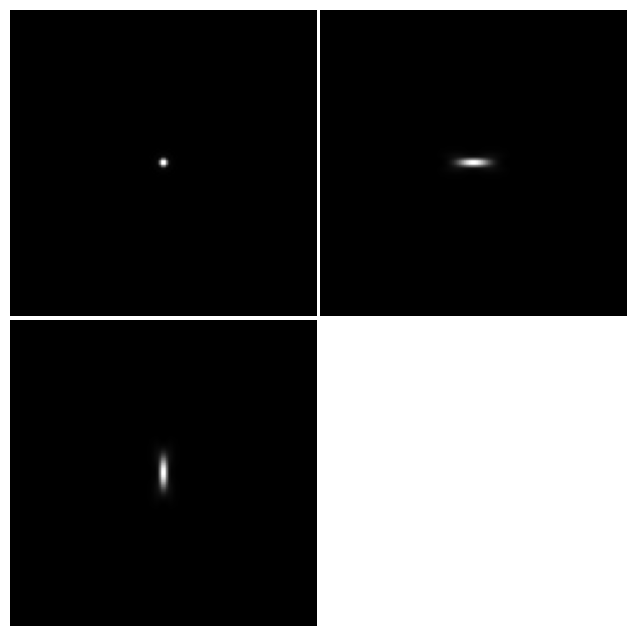

In [93]:
plot_orthogonal_views(cube_beads_psf, 
                      save_path="ortogonal_cube_psf_python.png")

In [56]:
number_of_iterations = 30
deconvolved = richardson_lucy_deconvolution(cube_beads_borrosa, cube_beads_psf, number_of_iterations)

(-0.5, 127.5, 127.5, -0.5)

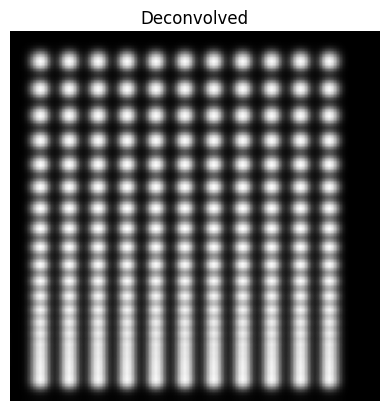

In [57]:
plt.imshow(deconvolved[30], cmap='gray')
plt.title('Deconvolved')
plt.axis('off') 

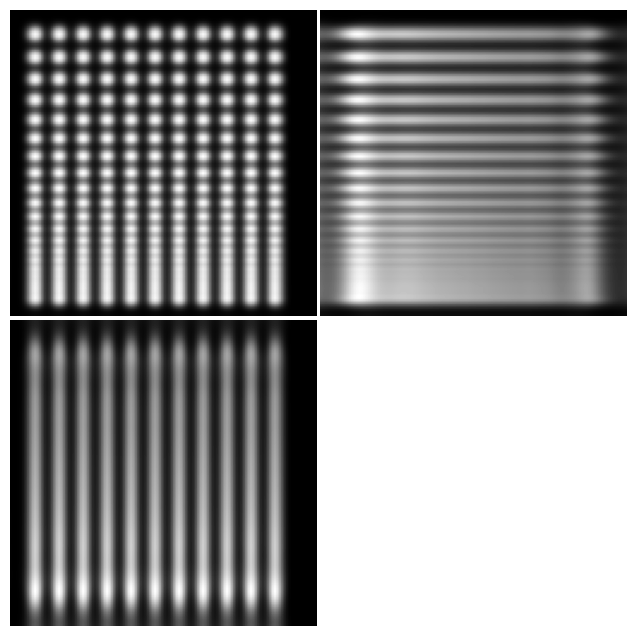

In [58]:
# Para tu volumen deconvolucionado
plot_orthogonal_views(deconvolved, 
                      save_path="deconvolved_cube_orthogonal_python.png")

<h3 style="color: green;">@ Benchmark</h3>

In [149]:
%timeit -n 1 -r 10  richardson_lucy_deconvolution(cube_beads_borrosa, cube_beads_psf, number_of_iterations)

2min 23s ± 706 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


---
## C. elegans embryo

In [4]:
import os

def load_image_stack(folder_path):
    # Listar todos los archivos en la carpeta y ordenar
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif') or f.endswith('.png') or f.endswith('.jpg')])

    # Leer la primera imagen para obtener las dimensiones
    first_image = iio.imread(os.path.join(folder_path, files[0]))
    height, width = first_image.shape

    # Crear una matriz 3D vacía para almacenar las imágenes
    image_stack = np.zeros((len(files), height, width), dtype=first_image.dtype)

    # Cargar cada imagen en la matriz 3D
    for i, file in enumerate(files):
        image_stack[i, :, :] = iio.imread(os.path.join(folder_path, file))

    return image_stack

## Canal 1

In [5]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath = '/Users/yi/TFGNotebook/CElegans-CY3'
psfPath = '/Users/yi/TFGNotebook/PSF-CElegans-CY3'

# Cargar las imágenes en una matriz 3D
image_stack = load_image_stack(imagePath)[:,0:356,0:336]
psf_stack = load_image_stack(psfPath)[:, 178:534, 168:504] #mitad +152

# Verificar las dimensiones de las matrices 3D
print(image_stack.shape)
print(psf_stack.shape)

(104, 356, 336)
(104, 356, 336)


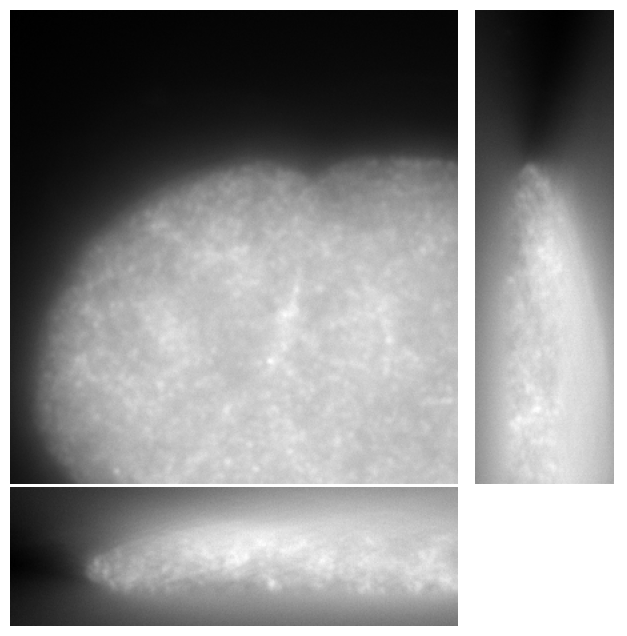

In [8]:
plot_orthogonal_views(image_stack, 
                      save_path="org_Celegans_orthogonal_python_C1.png")

(-0.5, 335.5, 355.5, -0.5)

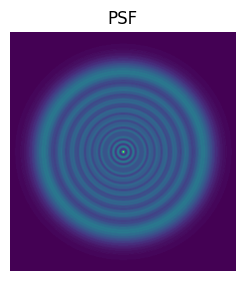

In [54]:
plt.subplot(1, 2, 2)
plt.imshow(psf_stack[1])
plt.title('PSF')
plt.axis('off')

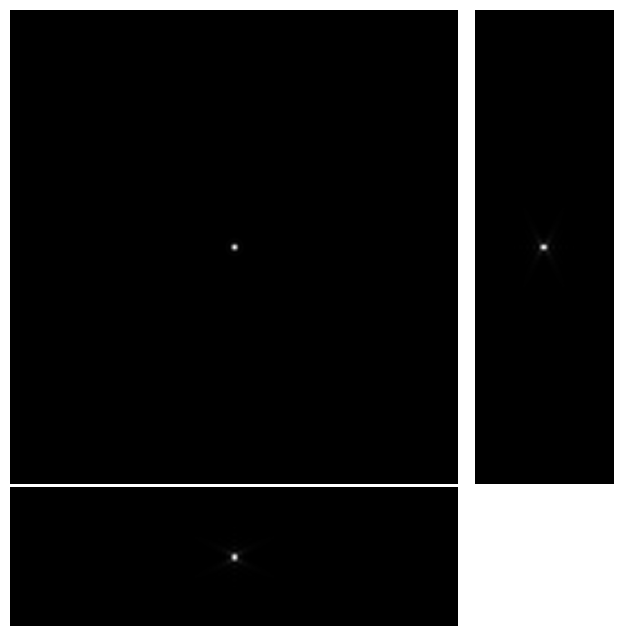

In [94]:
plot_orthogonal_views(psf_stack, 
                      save_path="psf_Celegans_orthogonal_python_C1.png")

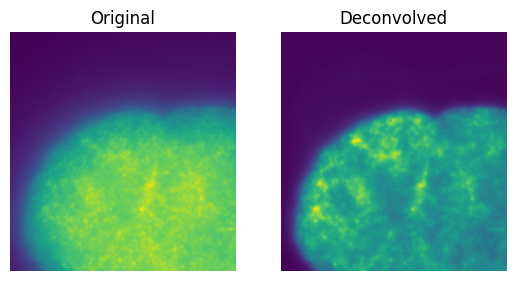

In [6]:
#deconvolved_stack = np.zeros_like(image_stack)
num_iterations = 50  # Número de iteraciones para el algoritmo de Richardson-Lucy

deconvolved_stack = richardson_lucy_deconvolution(image_stack, psf_stack, num_iterations)

# Reproducir un sonido en macOS
#os.system('say "COMPLETADO"')

# Visualizar un plano específico de la imagen deconvolucionada
plt.subplot(1, 2, 1)
plt.imshow(image_stack[52])
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(deconvolved_stack[52])
plt.title('Deconvolved')
plt.axis('off')

plt.show()



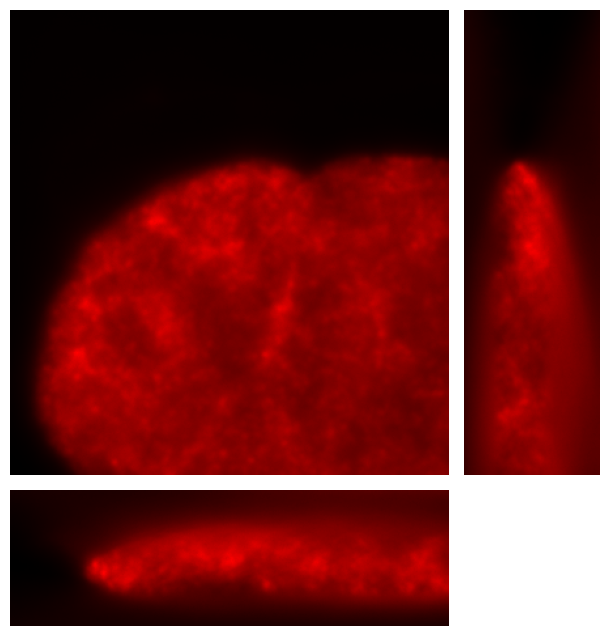

In [75]:
plot_orthogonal_views(deconvolved_stack, 
                      save_path="deconvolved_Celegans_orthogonal_python.png")

En Julia, la función save de la biblioteca ImageMagick.jl es muy similar a Pillow, ya que ambas son versátiles para guardar imágenes en varios formatos y ajustan automáticamente el tipo de datos. Pillow sería el más similar al método save de Julia en términos de funcionalidad y flexibilidad de formato.

In [6]:
# Extraer el stack 52
stack_52 = deconvolved_stack[52]

# Si stack_52 tiene valores entre 0 y 1, conviértelo a escala de 0 a 255
stack_52= (stack_52 - np.min(stack_52)) / (np.max(stack_52) - np.min(stack_52))  # Normalizar a [0, 1]
stack_52 = (stack_52 * 255).astype(np.uint8)

# Crear la imagen PIL desde el array y guardar en formato PNG
imagen = Image.fromarray(stack_52)
imagen.save('PythonITK_CANAL1_50iter.png')


<h3 style="color: green;">@ Benchmark</h3>

In [15]:
%timeit -n 1 -r 1  richardson_lucy_deconvolution(image_stack, psf_stack, 50)

6min 42s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Canal 2

In [76]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath2 = '/Users/yi/TFGNotebook/CElegans-DAPI'
psfPath2 = '/Users/yi/TFGNotebook/PSF-CElegans-DAPI'

# Cargar las imágenes en una matriz 3D
image_stack2 = load_image_stack(imagePath2)[:,0:356,0:336]
psf_stack2 = load_image_stack(psfPath2)[:, 178:534, 168:504] #mitad +152

# Verificar las dimensiones de las matrices 3D
print(image_stack2.shape)
print(psf_stack2.shape)

(104, 356, 336)
(104, 356, 336)


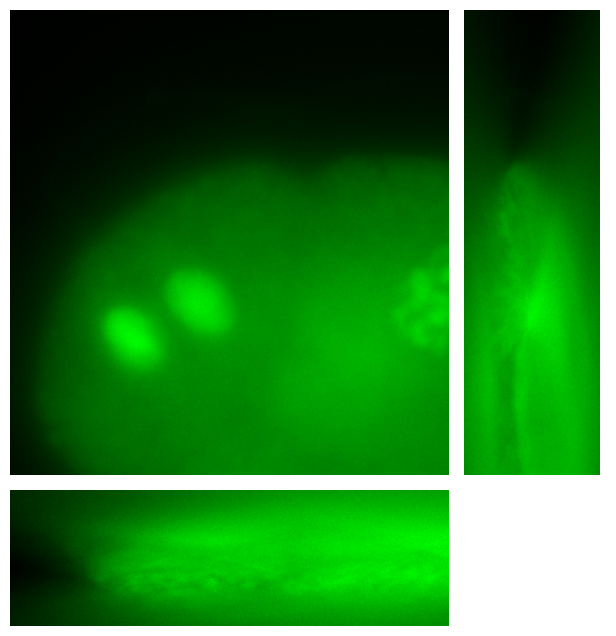

In [78]:
plot_orthogonal_views(image_stack2, 
                      save_path="org_Celegans_orthogonal_python_C2.png")

(-0.5, 335.5, 355.5, -0.5)

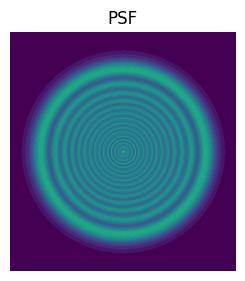

In [79]:
plt.subplot(1, 2, 2)
plt.imshow(psf_stack2[1])
plt.title('PSF')
plt.axis('off')

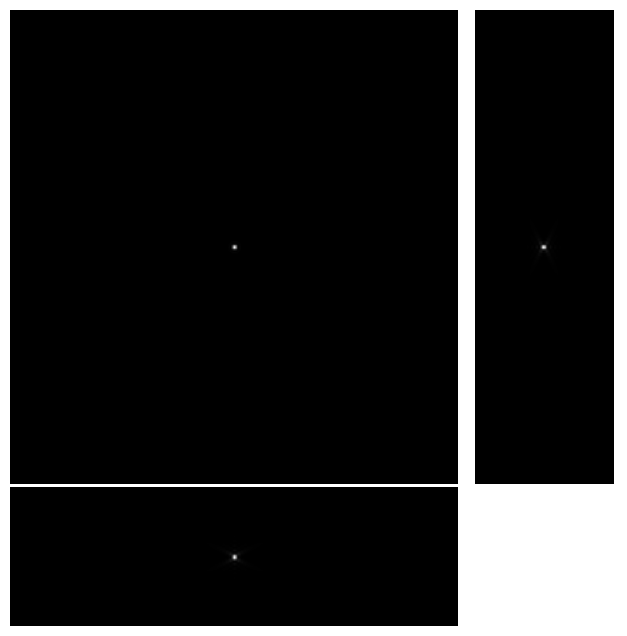

In [95]:
plot_orthogonal_views(psf_stack2, 
                      save_path="psf_Celegans_orthogonal_python_C2.png")

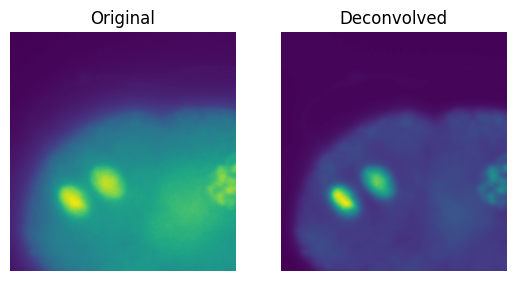

In [80]:
#deconvolved_stack2 = np.zeros_like(image_stack2)
num_iterations = 50  # Número de iteraciones para el algoritmo de Richardson-Lucy

deconvolved_stack2 = richardson_lucy_deconvolution(image_stack2, psf_stack2, num_iterations)

# Reproducir un sonido en macOS
# os.system('say "cocacola"')

# Visualizar un plano específico de la imagen deconvolucionada
plt.subplot(1, 2, 1)
plt.imshow(image_stack2[52])
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(deconvolved_stack2[52])
plt.title('Deconvolved')
plt.axis('off')

plt.show()

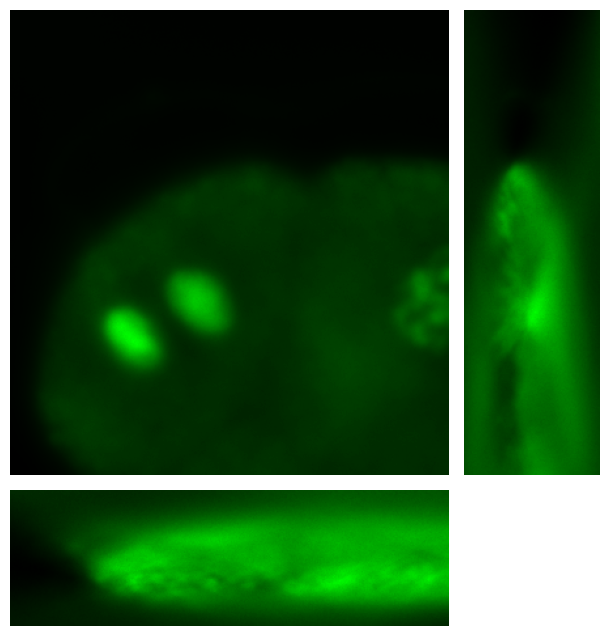

In [81]:
plot_orthogonal_views(deconvolved_stack2, 
                      save_path="50_deconvolved_Celegans_orthogonal_python_C2.png")

In [10]:
# Extraer el stack 52
stack_522 = deconvolved_stack2[52]

# Si stack_52 tiene valores entre 0 y 1, conviértelo a escala de 0 a 255
stack_522= (stack_522 - np.min(stack_522)) / (np.max(stack_522) - np.min(stack_522))  # Normalizar a [0, 1]
stack_522 = (stack_522 * 255).astype(np.uint8)

# Crear la imagen PIL desde el array y guardar en formato PNG
imagen2 = Image.fromarray(stack_522)
imagen2.save('PythonITK_CANAL2_50iter.png')


<h3 style="color: green;">@ Benchmark</h3>

In [8]:
%timeit -n 1 -r 1  richardson_lucy_deconvolution(image_stack2, psf_stack2, 20)

3min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Canal 3

In [82]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath3 = '/Users/yi/TFGNotebook/CElegans-FITC'
psfPath3 = '/Users/yi/TFGNotebook/PSF-CElegans-FITC'

# Cargar las imágenes en una matriz 3D
image_stack3 = load_image_stack(imagePath3)[:,0:356,0:336]
psf_stack3 = load_image_stack(psfPath3)[:, 178:534, 168:504] #mitad +152

# Verificar las dimensiones de las matrices 3D
print(image_stack3.shape)
print(psf_stack3.shape)

(104, 356, 336)
(104, 356, 336)


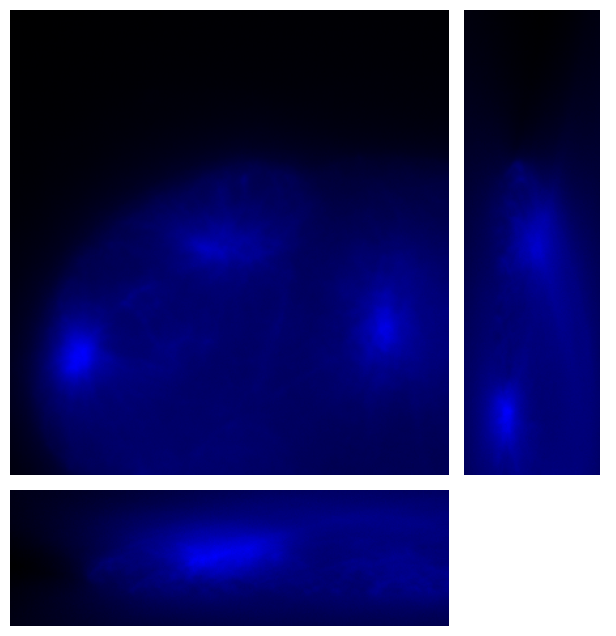

In [84]:
plot_orthogonal_views(image_stack3, 
                      save_path="org_Celegans_orthogonal_python_C3.png")

(-0.5, 335.5, 355.5, -0.5)

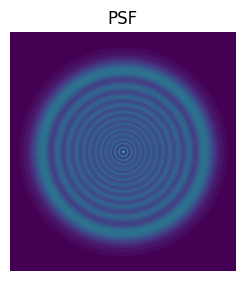

In [85]:
plt.subplot(1, 2, 2)
plt.imshow(psf_stack3[1])
plt.title('PSF')
plt.axis('off')

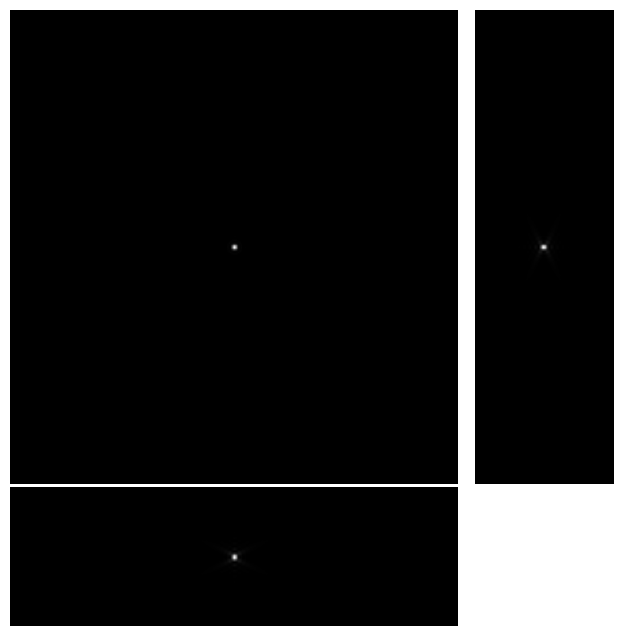

In [96]:
plot_orthogonal_views(psf_stack3, 
                      save_path="psf_Celegans_orthogonal_python_C3.png")

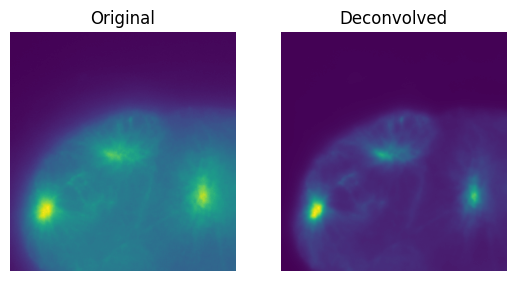

In [86]:
#deconvolved_stack3 = np.zeros_like(image_stack3)

num_iterations = 50  # Número de iteraciones para el algoritmo de Richardson-Lucy

deconvolved_stack3 = richardson_lucy_deconvolution(image_stack3, psf_stack3, num_iterations)


# Reproducir un sonido en macOS
#os.system('say "YEAH"')

# Visualizar un plano específico de la imagen deconvolucionada
plt.subplot(1, 2, 1)
plt.imshow(image_stack3[52])
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(deconvolved_stack3[52])
plt.title('Deconvolved')
plt.axis('off')

plt.show()

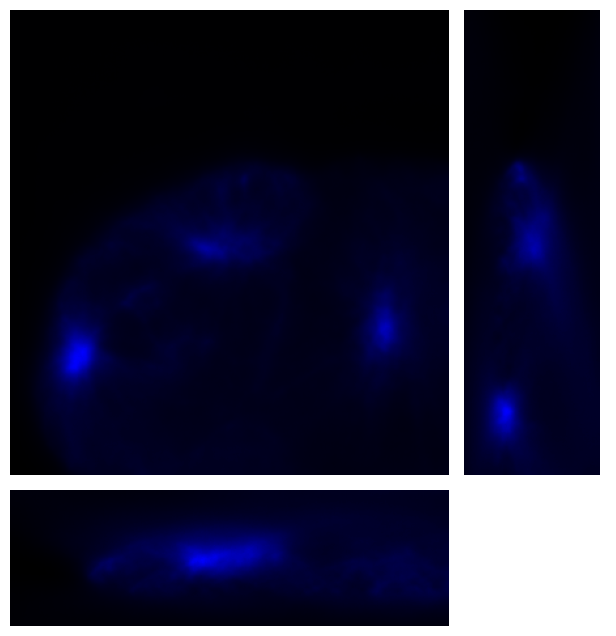

In [87]:
plot_orthogonal_views(deconvolved_stack3, 
                      save_path="50_deconvolved_Celegans_orthogonal_python_C3.png")

In [14]:
# Extraer el stack 52
stack_523 = deconvolved_stack3[52]

# Si stack_52 tiene valores entre 0 y 1, conviértelo a escala de 0 a 255
stack_523= (stack_523 - np.min(stack_523)) / (np.max(stack_523) - np.min(stack_523))  # Normalizar a [0, 1]
stack_523 = (stack_523 * 255).astype(np.uint8)

# Crear la imagen PIL desde el array y guardar en formato PNG
imagen3 = Image.fromarray(stack_523)
imagen3.save('PythonITK_CANAL3_50iter.png')

<h3 style="color: green;">@ Benchmark</h3>

In [28]:
%timeit -n 1 -r 1  richardson_lucy_deconvolution(image_stack3, psf_stack3, 50)

6min 59s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### Combinación de canales

(-0.5, 335.5, 355.5, -0.5)

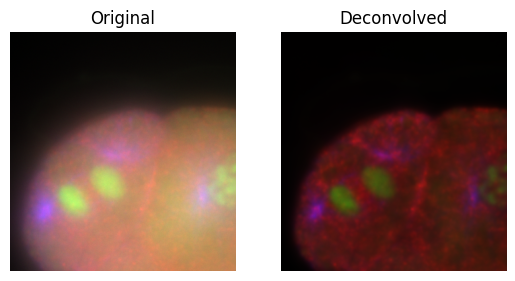

In [25]:
# Normalizar los canales (opcional, pero recomendado)
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    if min_val == max_val:
        return np.zeros_like(image)  # O np.ones_like(image), dependiendo de tu preferencia
    return (image - min_val) / (max_val - min_val)
deconvolved_stack_R = normalize(deconvolved_stack)
deconvolved_stack_G = normalize(deconvolved_stack2)
deconvolved_stack_B = normalize(deconvolved_stack3)

# Combinar los tres canales en una sola matriz 4D (profundidad, altura, ancho, canales)
deconvolved_stack_color = np.stack((deconvolved_stack_R, deconvolved_stack_G, deconvolved_stack_B), axis=-1)

# Guardar las imágenes en formato PNG
iio.imwrite('imagenDeconvolucionada_100150150_PythonMejora.png', (deconvolved_stack_color[52] * 255).astype(np.uint8))


# Visualizar un plano específico de la imagen deconvolucionada en color
plt.subplot(1, 2, 1)
plt.imshow(np.stack((normalize(image_stack[52]), normalize(image_stack2[52]), normalize(image_stack3[52])), axis=-1))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(deconvolved_stack_color[52])
plt.title('Deconvolved')
plt.axis('off')


Visualización con NAPARI:

In [ ]:
import napari
import numpy as np

# Colores para cada canal
colormaps = ['red', 'green', 'blue']

# Crear viewer 3D
viewer = napari.Viewer(ndisplay=3)

# Añadir cada canal como capa independiente
channels = [deconvolved_stack, deconvolved_stack2, deconvolved_stack3]
for i, channel in enumerate(channels):
    viewer.add_image(
        channel,
        name=f'Canal {i+1}',
        colormap=colormaps[i],
    )

# Dimensiones del volumen para los ejes
Z, Y, X = deconvolved_stack.shape

# Crear ejes X, Y, Z
axes_lines = [
    np.array([[0, 0, 0], [Z, 0, 0]]),  # eje Z
    np.array([[0, 0, 0], [0, Y, 0]]),  # eje Y
    np.array([[0, 0, 0], [0, 0, X]])   # eje X
]

viewer.add_vectors(axes_lines, edge_color=['red', 'green', 'blue'], edge_width=3)

# Ejecutar Napari
napari.run()


---
## Prueba adicional: microtubulos

In [91]:
micro_borrosa = img_as_float(iio.imread("microtubulos.tif"))

(-0.5, 511.5, 255.5, -0.5)

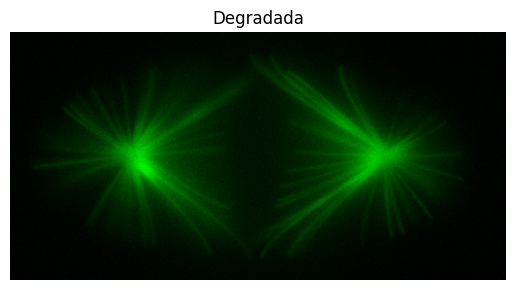

In [148]:
# Creamos un colormap de negro a verde fluorescente
fluorescent_green = LinearSegmentedColormap.from_list('fluoro_green', ['black', (0,1,0)])

plt.imshow(micro_borrosa[64], cmap=fluorescent_green)
plt.title('Degradada')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

In [93]:
micro_borrosa.shape

(128, 256, 512)

In [92]:
micro_psf = img_as_float(iio.imread("microtubulos_psf.tif"))

(-0.5, 511.5, 255.5, -0.5)

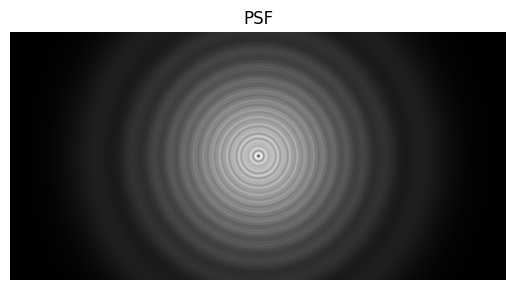

In [105]:
plt.imshow(micro_psf[127], cmap='gray')
plt.title('PSF')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

Tardó 23 minutos aprox, la imagen es bastante grande

In [ ]:
number_of_iterations = 30
deconvolved_micro = richardson_lucy_deconvolution(micro_borrosa, micro_psf, number_of_iterations)

(-0.5, 511.5, 255.5, -0.5)

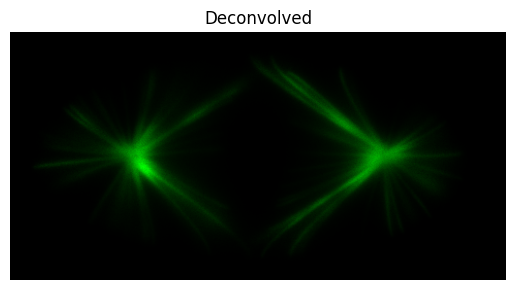

In [147]:
plt.imshow(deconvolved_micro[64], cmap=fluorescent_green)
plt.title('Deconvolved')
plt.axis('off') 

In [22]:
from scipy.io import loadmat

data = loadmat('3D_WBD_CElegans_C3.mat')
volume_matlab = data['outputChannel3']  # shape: (Y, X, Z)
volume_3d = np.transpose(volume_matlab, (2, 0, 1))  # ahora es (Z, Y, X)

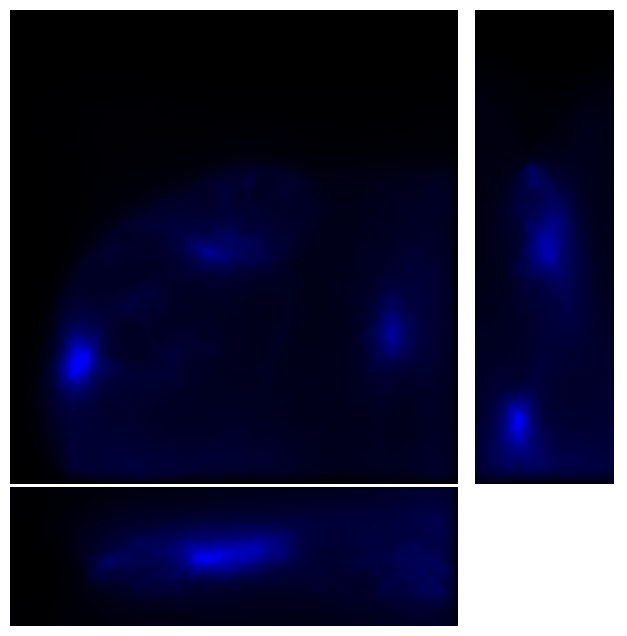

In [23]:
plot_orthogonal_views(volume_3d, 
                      save_path="3D_WBD_CElegans_C3.png")